In [52]:
# 使用SimpleTagBased算法对Delicious2K数据进行推荐
# 原始数据集：https://grouplens.org/datasets/hetrec-2011/
# 数据格式：userID     bookmarkID     tagID     timestamp
import random
import math
import operator
import pandas as pd

file_path = "./user_taggedbookmarks-timestamps.dat"
# 字典类型，保存了user对item的tag，即{userid: {item1:[tag1, tag2], ...}}
records = {}
# 训练集，测试集
train_data = dict()
test_data = dict()
# 用户标签，商品标签
user_tags = dict()
tag_items = dict()
user_items = dict()

In [57]:
# 增加一些dict
item_tags = dict()
tag_users = dict()
item_users = dict()

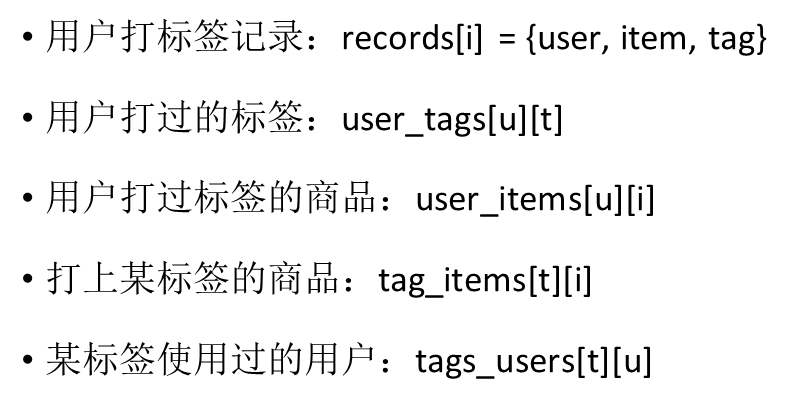!

In [66]:
df = pd.read_csv(file_path, sep='\t')

In [19]:
df.tail()

,userID,bookmarkID,tagID,timestamp
437588,108035,30993,193,1277495315000
437589,108035,30993,673,1277495315000
437590,108035,30994,130,1277223715000
437591,108035,30994,267,1277223715000
437592,108035,30994,4943,1277223715000


In [41]:
len(records.keys())

1867

In [65]:
# 使用测试集，计算准确率和召回率
def precisionAndRecall(N):
    hit = 0
    h_recall = 0
    h_precision = 0
    for user,items in test_data.items():
        if user not in train_data:
            continue
        # 获取Top-N推荐列表
        rank = recommend(user, N)
        for item,rui in rank:
            if item in items:
                hit = hit + 1
        h_recall = h_recall + len(items)
        h_precision = h_precision + N
    #print('一共命中 %d 个, 一共推荐 %d 个, 用户设置tag总数 %d 个' %(hit, h_precision, h_recall))
    # 返回准确率 和 召回率
    return (hit/(h_precision*1.0)), (hit/(h_recall*1.0))

# 使用测试集，对推荐结果进行评估
def testRecommend():
    print("推荐结果评估")
    print("%3s %10s %10s" % ('N',"精确率",'召回率'))
    for n in [5,10,20,40,60,80,100]:
        precision,recall = precisionAndRecall(n)
        print("%3d %10.3f%% %10.3f%%" % (n, precision * 100, recall * 100))
        
# 数据加载
def load_data():
    print("开始数据加载...")
    df = pd.read_csv(file_path, sep='\t')
    for i in range(len(df)):
        uid = df['userID'][i]
        iid = df['bookmarkID'][i]
        tag = df['tagID'][i]
        # 键不存在时，设置默认值{}
        records.setdefault(uid,{})
        records[uid].setdefault(iid,[])
        records[uid][iid].append(tag)
    print("数据集大小为 %d." % (len(df)))
    print("设置tag的人数 %d." % (len(records)))
    print("数据加载完成\n")

# 将数据集拆分为训练集和测试集
def train_test_split(ratio, seed=100):
    random.seed(seed)
    for u in records.keys():
        for i in records[u].keys():
            # ratio比例设置为测试集
            if random.random()<ratio:
                test_data.setdefault(u,{})
                test_data[u].setdefault(i,[])
                for t in records[u][i]:
                    test_data[u][i].append(t)
            else:
                train_data.setdefault(u,{})
                train_data[u].setdefault(i,[])
                for t in records[u][i]:
                    train_data[u][i].append(t)        
    print("训练集样本数 %d, 测试集样本数 %d" % (len(train_data),len(test_data)))

# 设置矩阵 mat[index, item] = 1
def addValueToMat(mat, index, item, value=1):
    if index not in mat:
        mat.setdefault(index,{})
        mat[index].setdefault(item,value)
    else:
        if item not in mat[index]:
            mat[index][item] = value
        else:
            mat[index][item] += value


# 使用训练集，初始化user_tags, tag_items, user_items
def initStat():
    records=train_data
    for u,items in records.items():
        for i,tags in items.items():
            for tag in tags:
                #print tag
                # 用户和tag的关系
                addValueToMat(user_tags, u, tag, 1)
                # tag和item的关系
                addValueToMat(tag_items, tag, i, 1)
                # 用户和item的关系
                addValueToMat(user_items, u, i, 1)
                # item喝tag的关系
                addValueToMat(item_tags,i,tag,1)
                # tag和用户的关系
                addValueToMat(tag_users,tag,u,1)
                # items和用户的关系
                addValueToMat(item_users,i,u,1)
    print("user_tags, tag_items, user_items初始化完成.")
    print("user_tags大小 %d, tag_items大小 %d, user_items大小 %d" % (len(user_tags), len(tag_items), len(user_items)))


In [63]:
# 对用户user推荐Top-N
def recommend(user, N):
    recommend_items=dict()
    # 对Item进行打分，分数为所有的（用户对某标签使用的次数 wut, 乘以 商品被打上相同标签的次数 wti）之和
    tagged_items = user_items[user]     
    for tag, wut in user_tags[user].items():
        #print(self.user_tags[user].items())
        for item, wti in tag_items[tag].items():
            if item in tagged_items:
                continue
                
            # NormTagBased 算法
            norm = len(tag_users[tag].items())*len(user_tags[user].items())
            # TagBased-IDF 算法
#             norm = math.log(len(tag_users[tag].items()) + 1)
            #print('wut = %s, wti = %s' %(wut, wti))
            if item not in recommend_items:
                recommend_items[item] = wut * wti / norm 
            else:
                recommend_items[item] = recommend_items[item] + wut * wti / norm
    return sorted(recommend_items.items(), key=operator.itemgetter(1), reverse=True)[0:N]

In [67]:
# 数据加载
load_data()
# 训练集，测试集拆分，20%测试集
train_test_split(0.2)
initStat()

开始数据加载...
数据集大小为 437593.
设置tag的人数 1867.
数据加载完成

训练集样本数 1860, 测试集样本数 1793
user_tags, tag_items, user_items初始化完成.
user_tags大小 1860, tag_items大小 36884, user_items大小 1860


In [64]:
# SimpleTagBased算法推荐结果
testRecommend()

推荐结果评估
  N        精确率        召回率
  5      0.829%      0.355%
 10      0.633%      0.542%
 20      0.512%      0.877%
 40      0.381%      1.304%
 60      0.318%      1.635%
 80      0.276%      1.893%
100      0.248%      2.124%


In [62]:
# NormTagBased算法推荐结果
testRecommend()

推荐结果评估
  N        精确率        召回率
  5      0.907%      0.388%
 10      0.638%      0.546%
 20      0.507%      0.868%
 40      0.356%      1.218%
 60      0.287%      1.476%
 80      0.255%      1.750%
100      0.241%      2.061%


In [60]:
# TagBased-TFIDF算法推荐结果
testRecommend()

推荐结果评估
  N        精确率        召回率
  5      1.008%      0.431%
 10      0.761%      0.652%
 20      0.549%      0.940%
 40      0.402%      1.376%
 60      0.328%      1.687%
 80      0.297%      2.033%
100      0.269%      2.306%
